# Particle simulation vs Langevin model

In [31]:
include("../src/bmparticles.jl")
include("../src/bmtheory.jl")
using .BParts
using .Theorist

In [7]:
using DifferentialEquations, Distributions, LaTeXStrings

In [8]:
using Plots
# plotly()
gr()


Plots.GRBackend()

## Fixed Density

First we compare the particle simulation with the simulations of the Langevin equation (and some analytical results from it) for a fixed population size.

When comparing the two we must take care to ensure both approaches are modeling the same system. In particular, a particle modeled by the Langevin equation has its future speed distribution initially determined by the energy of the system, as it is parameterized by $D/\gamma$ (see equation (3) in document) which can be equated to the average energy per particle $\left< E \right>$ (4); however in the simulation particles are introduced into the system with a speed rather than an energy. If the simulation is initiated with all particles having the same speed -- which is convenient to ensure the system evolves to the predetermined equilibrium, as opposed to drawing their speeds from the desired distribution in which case the system energy becomes a random variable -- we must ensure the average energy matches that of the Langevin particle. We know that
\begin{equation}
    \left< E \right> = \frac{\left< v^2 \right>}{2}
\end{equation}
thus using $\left< v_0^2 \right> = \left< s_0^2 \right> = s_0^2$ (since all particles have the same speed initially) we know that the initial particle speed and the average energy per particle are related through
\begin{align}
    s_0 = \sqrt{2\left< E \right>} \\
    \left< E \right> = \frac{s_0^2}{2}
\end{align}
Note that as the system evolves the particle speeds should become distributed according to the Rayleigh distribution, and the average speed becomes
\begin{equation}
    \left< s \right> = \sqrt{E} \sqrt{\frac{\pi}{2}}
\end{equation}

### Parameters for simulation

In [9]:
function extendParams!(arenaParams::Dict)
    bounds = arenaParams["bounds"]
    arenaParams["volume"] = abs(bounds[1][2]-bounds[1][1])*abs(bounds[2][2]-bounds[2][1])
    arenaParams["bperiod"] = [abs(bounds[1][2]-bounds[1][1]), abs(bounds[2][2]-bounds[2][1])]
end

extendParams! (generic function with 1 method)

In [10]:
arenaParams = 
    Dict(
        "n0"=>1000,
        "evolveTime"=> 2000,
        "bounds"=>((0.,20.),(0.,20.)), 
        "radius"=>0.08, 
        "speed"=>0.03
    )

extendParams!(arenaParams)
for p in arenaParams
    println(p)
end


Pair{String,Any}("volume", 400.0)
Pair{String,Any}("evolveTime", 2000)
Pair{String,Any}("speed", 0.03)
Pair{String,Any}("radius", 0.08)
Pair{String,Any}("bounds", ((0.0, 20.0), (0.0, 20.0)))
Pair{String,Any}("bperiod", [20.0, 20.0])
Pair{String,Any}("n0", 1000)


In [11]:
thermVals = Theorist.thermalValues(arenaParams)


Dict{Any,Any} with 7 entries:
  "γ"  => 0.0300795
  "ρ"  => 0.0502655
  "σc" => 0.32
  "D"  => 1.35358e-5
  "l"  => 0.883883
  "E"  => 0.00045
  "n"  => 2.5

### Simulations

run a particle simulation:

In [12]:
arena, pos_t_dim_id, vel_t_dim_id, cells_T_ID = 
    BParts.randArenaEvolve(arenaParams["n0"], arenaParams["evolveTime"], arenaParams);

println("energy per cell: ",
        BParts.kineticEnergy(arena) / arenaParams["n0"]
    )



Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


energy per cell: 0.00044999999999999966


Run an ensemble of Langevin equations:

In [35]:
@time langevinEnsemble = Theorist.runLangevinSims(5000, arenaParams);

Energy: 0.00045


### Analysis

Speed distributions:

For a well mixed population the particle speeds are predicted to be Rayleigh distributed with shape parameter $\sigma = \sqrt{E}$ where $E$ is the average particle energie.

In [36]:
evolveTime = arenaParams["evolveTime"]
speedPar_t_id = BParts.speedCalc(vel_t_dim_id)
speedLan_t_id = Theorist.speedCalc(langevinEnsemble, 1:evolveTime)
rDistPred = Rayleigh( sqrt(thermVals["E"]) );


In [15]:
speedMeanPar = mean(speedPar_t_id[500:end,:])
speedMeanLan = mean(speedLan_t_id)
speedMeanTheory = √(thermVals["E"])*sqrt(π/2)

println(speedMeanLan)
println(speedMeanPar)
println(speedMeanTheory)

0.026203112896902046
0.026573335843347246
0.02658680776358274


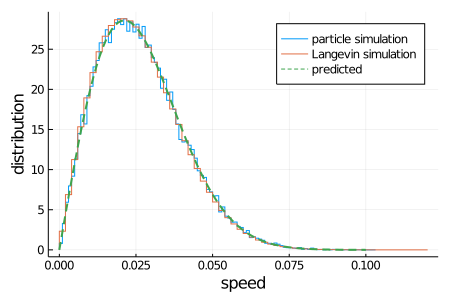

In [37]:
p1 =
histogram(vec(speedPar_t_id[500:end,:,:]), bins=100, normalize=true, label="particle simulation", 
    size=(450,300), dpi=100)
histogram!(vec(speedLan_t_id), bins=100, normalize=true, label="Langevin simulation")
plot!(range(0,0.10, length=100), pdf.(rDistPred, range(0,0.10, length=100)), 
    linestyle=:dash, linewidth=2, label="predicted")
xlabel!("speed")
ylabel!("distribution")
display(p1)

# savefig(p1, "../figures/fixedDensity_speedDist.png")


The velocity autocorrelation is expected to be described by
\begin{equation}
    \left< v(t)v(t+\tau) \right> = 2E e^{-\gamma \tau}
\end{equation}
where $\gamma$ is determined by the density through the mean free path $l$:
\begin{equation}
    \gamma = \frac{\sqrt{E}}{l} \sqrt{ \frac{\pi}{2} }
\end{equation}
which in turn is determined by the particle density $n$:
\begin{equation}
    l = \frac{1}{\sqrt{2}\sigma n}
\end{equation}
As such this is a good test to check whether a test particle's movement can in fact be modeled by a density coupled Brownian motion.

In [38]:
corrTime = 400
timesCorr_t, vCorrLan_t = Theorist.velCorrelation(langevinEnsemble, (1,corrTime), steps=corrTime);
vCorrPar_t = BParts.velocityAutocorrelation(vel_t_dim_id[1:corrTime, :, :]);
vCorrPred_t = map( t->2*thermVals["E"]*exp(-thermVals["γ"]*t), 0:corrTime-1 );


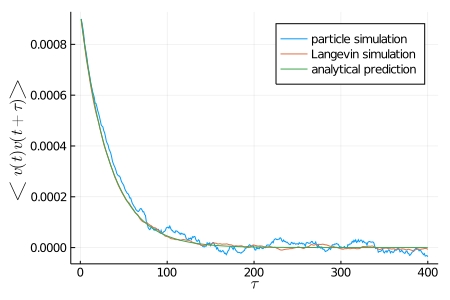

In [39]:
p2 = plot(timesCorr_t, vCorrPar_t, label="particle simulation", size=(450,300), dpi=100)
plot!(timesCorr_t, vCorrLan_t, label="Langevin simulation")
plot!(timesCorr_t, vCorrPred_t, label="analytical prediction")
xlabel!(L"\tau")
ylabel!(L"\left< v(t)v(t+\tau) \right>")
display(p2)

# savefig(p2, "../Figures/fixedDensity_velautocorr.png")


Mean squared displacement:

In [42]:
msdTimes = (100, 2000)
timesMSD_t, msdLan_t = Theorist.msd(langevinEnsemble, arenaParams,  msdTimes);
msdPar_t = BParts.meanSquaredDisplacement(pos_t_dim_id, msdTimes);


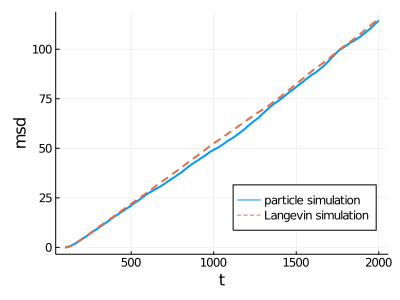

In [43]:
p2 = plot(timesMSD_t, msdPar_t, label="particle simulation", linewidth=2, 
    legend=:bottomright, size=(400,300))
plot!(timesMSD_t, msdLan_t, label="Langevin simulation", linewidth=2, linestyle=:dash)
xlabel!("t")
ylabel!("msd")
display(p2)

# savefig(p2, "../Figures/fixedDensity_msd.pdf")


Note that the msd can become sublinear after a particular distance due to the periodic boundaries. The effect can be removed by increasing the arena size.